## Loading Necessary Packages 

In [1]:
using Pkg
Pkg.activate("new_environment_name")  # Create a new environment
Pkg.add("Flux") # and add all the required packages to this environment.

using Flux, Optim
using Flux: params, train!
using Zygote: gradient
using Random
import QuasiMonteCarlo
using Statistics

  Activating project at `~/Desktop/December2023/new_environment_name`


    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/Desktop/December2023/new_environment_name/Project.toml`
  No Changes to `~/Desktop/December2023/new_environment_name/Manifest.toml`


## Neural Network Definition:
### We defined NN architecture with Flux which is a machine learning library in Julia, this NN has 2 layers: the first layer is a dense (fully connected) layer with 2 input neurons (corresponding to x and y), 64 output neurons, and tanh (hyperbolic tangent) as the activation function, the second layer is also fully conncected layer that takes 64 inputs (from the previous layer) and outputs a single value.
### In the end, we define our PDE as a trial function and its boundary conditions that are Zero. 
$$\Delta u = {2x(y-1)(y-2x+xy+2)e^{x-y} }$$
$$ u : [0,1] \to [0,1]$$
$$ u(0,y) = u(x,0) = u(x,1) = u(1,x) = 0$$ 

In [2]:
# Neural network
nn = Chain(Dense(2, 64, tanh), Dense(64, 1))

al = 100

# Trial function with boundary conditions
function u(x, y, nn)
    f = 2*x*(y-1)*(y-2*x+x*y+2)*exp(x-y)
    return (1 - x) * x * (1 - y) * y * (nn([x, y])[1] + f)
end

u (generic function with 1 method)

## Loss Function
### The loss function calculates the squared error between a predicted solution of a differential equation and its actual behavior. It does this by:

### 1. Computing the predicted solution u_pred using the neural network nn and the trial function u.
### 2. Estimating the second partial derivatives of u with respect to x (u_xx) and y (u_yy) using a central difference formula, which is a numerical method for approximating derivatives.
### 3. Calculating the Laplacian of u (sum of these second derivatives, Δu).
### 4. Computing a reference function f based on x, y, and a constant al.
### 5. Returning the squared difference between the Laplacian Δu and the reference function f. This difference represents the error in the neural network's prediction of the differential equation's behavior.

In [3]:
function loss(x, y, nn)
    u_pred = u(x, y, nn)
    h = 1e-5
    u_xx = (u(x + h, y, nn) - 2 * u_pred + u(x - h, y, nn)) / h^2
    u_yy = (u(x, y + h, nn) - 2 * u_pred + u(x, y - h, nn)) / h^2
    Δu = u_xx .+ u_yy
    f = 2*x*(y-1)*(y-2*x+x*y+2)*exp(x-y)
    return (Δu - f)^2
end

loss (generic function with 1 method)

## Calculating Gradient of the Loss Function 
### This code defines a function loss_gradients that calculates the gradients of a loss function with respect to the parameters of a neural network. It's used in training the neural network to optimize its parameters for better accuracy in solving a differential equation. The function computes the loss for given inputs (x, y) and the neural network (nn), and then it calculates how this loss changes with respect to each parameter of the network. This information is used to adjust the network's parameters during training.

In [4]:
function loss_gradients(x, y, nn, ps)
    l = loss(x, y, nn)
    return gradient(() -> l, ps)
end

loss_gradients (generic function with 1 method)

## Training the NN

In [5]:
batch_size = 1000
function train_pde_solver(nn, epochs, batch_size)
    opt = ADAM(0.01)
    ps = params(nn)

    for epoch in 1:epochs
        batch_x = rand(batch_size)
        batch_y = rand(batch_size)
        grads = loss_gradients.(batch_x, batch_y, Ref(nn), Ref(ps))
        agg_grads = sum(grads)

        Flux.Optimise.update!(opt, ps, agg_grads)
        
        if epoch % 100 == 0
            println("Epoch: $epoch, Loss: $(loss(rand(), rand(), nn))")
        end
    end
end

train_pde_solver (generic function with 1 method)

## Error Calculation

In [6]:
function calculate_error(u, nn, reference_solution, resolution=100)
    x_range = range(0, 1, length=resolution)
    y_range = range(0, 1, length=resolution)

    errors = [abs(u(x, y, nn) - reference_solution(x, y)) for x in x_range, y in y_range]
    
    return mean(errors)
end

calculate_error (generic function with 2 methods)

## Defining the Reference Solution

In [8]:
function reference_solution(x, y)
    return exp(x-y)*x*(1-x)*y*(1-y)
end

reference_solution (generic function with 1 method)

## Error Calculation

In [9]:
error = calculate_error(u, nn, reference_solution)
println("Error between the prediction and the reference solution: $error")

using Plots

Error between the prediction and the reference solution: 0.05268124564771037


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 64, tanh)
│   summary(x) = 2-element Vector{Float64}
└ @ Flux /Users/faezehbahadorirad/.julia/packages/Flux/n3cOc/src/layers/stateless.jl:60


## Plotting the Results

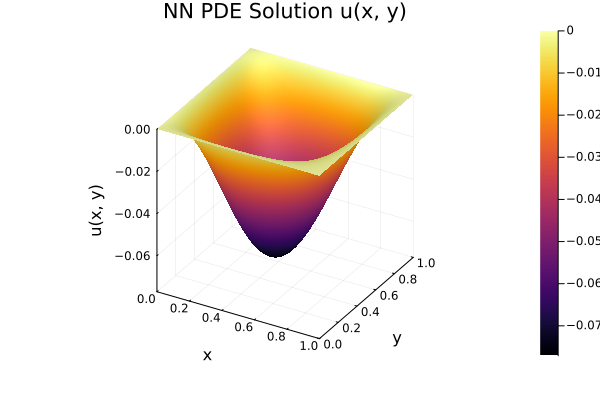

In [10]:
function plot_solution_3d(u, nn, resolution=1000)
    x_range = range(0, 1, length=resolution)
    y_range = range(0, 1, length=resolution)


    # Calculate u(x, y) values on the grid
    u_values = [u(x, y, nn) for x in x_range, y in y_range] 
    # Create a 3D surface plot of the solution
    surface(x_range, y_range, u_values, xlabel="x", ylabel="y", zlabel="u(x, y)", title="NN PDE Solution u(x, y)")

end
x_range = range(0, 1, length=100)
y_range = range(0, 1, length=100)
u_true = [reference_solution(x, y) for x in x_range, y in y_range]

plot_solution_3d(u, nn)